# 제품 이상여부 판별 프로젝트


### 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [34]:
ROOT_DIR = "data"
RANDOM_STATE = 110


# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lg aimers 5기/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lg aimers 5기/test.csv')
# Load data
#df = pd.read_csv('data/train.csv')
#test_df = pd.read_csv('data/test.csv')

In [35]:
df.head(5)
print(df.shape)
#40506행, 464열

(40506, 464)


###3개 컬럼 결측치 고민

In [36]:
#결측치 제거 - 모든 행이 결측치면 삭제
dr=df.isnull().sum().sort_values()[-281:].index
df.drop(columns=dr,inplace=True)
test_df.drop(columns=dr,inplace=True)

In [37]:
#고유값이 하나면 모델 학습에 영향을 주지 못할 것이라 판단, 삭제
dr_0=df.nunique().sort_values()[:64].index
df.drop(columns=dr_0,inplace=True)
test_df.drop(columns=dr_0,inplace=True)

In [38]:
#남은 컬럼은 119 컬럼
df.head(5)

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,428.0,243.7,243.7,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.6,7.0,185,1,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,1324.2,243.5,243.5,243.5,114.612,19.8,10.0,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,1324.2,243.5,243.5,243.5,85.000,19.9,12.0,268,1,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.7,8.0,121,1,Normal


## 주요 변수 분별

In [39]:
df['Equipment'] = list(zip(df['Equipment_Dam'],df['Equipment_Fill1'],df['Equipment_Fill2']))
test_df['Equipment'] = list(zip(test_df['Equipment_Dam'],test_df['Equipment_Fill1'],test_df['Equipment_Fill2']))

In [40]:
# 'Equipment' 열의 값이 특정 문자열과 일치하는 행만 선택
target_value = ('Dam dispenser #1', 'Fill1 dispenser #1', 'Fill2 dispenser #1')

df = df[df['Equipment'] == target_value]
test_df = test_df[test_df['Equipment'] == target_value]

In [41]:
df['Head Zero Position Collect Result_Dam'] = list(zip(df['Head Zero Position Y Collect Result_Dam'],df['Head Zero Position Z Collect Result_Dam']))
df['HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Dam'] = list(zip(df['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'],df['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'],df['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']))
df['HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam'] = list(zip(df['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'],df['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'],df['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']))
df['HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam'] = list(zip(df['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'],df['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'],df['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']))
df['HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Fill1'] = list(zip(df['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'],df['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'],df['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']))
df['HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Fill1'] = list(zip(df['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'],df['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'],df['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']))
df['HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Fill1'] = list(zip(df['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'],df['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'],df['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']))
df['CURE END POSITION Collect Result_Fill2'] = list(zip(df['CURE END POSITION X Collect Result_Fill2'],df['CURE END POSITION Z Collect Result_Fill2']))
df['CURE START POSITION Collect Result_Fill2'] = list(zip(df['CURE START POSITION X Collect Result_Fill2'],df['CURE START POSITION Z Collect Result_Fill2']))


test_df['Head Zero Position Collect Result_Dam'] = list(zip(test_df['Head Zero Position Y Collect Result_Dam'],test_df['Head Zero Position Z Collect Result_Dam']))
test_df['HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Dam'] = list(zip(test_df['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'],test_df['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'],test_df['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']))
test_df['HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam'] = list(zip(test_df['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'],test_df['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'],test_df['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']))
test_df['HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam'] = list(zip(test_df['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'],test_df['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'],test_df['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']))
test_df['HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Fill1'] = list(zip(test_df['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'],test_df['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'],test_df['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']))
test_df['HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Fill1'] = list(zip(test_df['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'],test_df['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'],test_df['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']))
test_df['HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Fill1'] = list(zip(test_df['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'],test_df['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'],test_df['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']))
test_df['CURE END POSITION Collect Result_Fill2'] = list(zip(test_df['CURE END POSITION X Collect Result_Fill2'],test_df['CURE END POSITION Z Collect Result_Fill2']))
test_df['CURE START POSITION Collect Result_Fill2'] = list(zip(test_df['CURE START POSITION X Collect Result_Fill2'],test_df['CURE START POSITION Z Collect Result_Fill2']))


In [42]:
columns_to_drop = ['Head Zero Position Y Collect Result_Dam','Head Zero Position Z Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                   'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam','HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
                   'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam','HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
                   'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam','HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
                   'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1','HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1','HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
                   'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1','HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1','HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
                   'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1','HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1','HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
                   'CURE END POSITION X Collect Result_Fill2','CURE END POSITION Z Collect Result_Fill2',
                   'CURE START POSITION X Collect Result_Fill2' ,'CURE START POSITION Z Collect Result_Fill2','Equipment'
                   ]

df = df.drop(columns=columns_to_drop, errors='ignore')
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')


In [43]:
columns_to_category = ['Head Clean Position Z Collect Result_Dam', 'Head Purge Position Z Collect Result_Dam','Head Zero Position Collect Result_Dam',
                       'HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Dam','HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam',
                       'HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam','HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Fill1',
                       'HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Fill1','HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Fill1',
                       'Head Purge Position Z Collect Result_Fill1','CURE END POSITION Collect Result_Fill2','CURE STANDBY POSITION Z Collect Result_Fill2',
                       'CURE START POSITION Collect Result_Fill2','Head Purge Position Z Collect Result_Fill2']


# 실수값을 문자열로 변환 (수정된 예)
for col in columns_to_category:
    if col in df.columns:
        df[col] = df[col].astype(str)  # 실수값 및 기타 값들을 문자열로 변환
        df[col] = df[col].astype('category')  # 범주형 데이터로 변환
    else:
        print(f"Column {col} does not exist in DataFrame")

for col in columns_to_category:
    if col in test_df.columns:
        test_df[col] = test_df[col].astype(str)  # 실수값 및 기타 값들을 문자열로 변환
        test_df[col] = test_df[col].astype('category')  # 범주형 데이터로 변환
    else:
        print(f"Column {col} does not exist in DataFrame")

In [44]:
#중복 컬럼 삭제
dr2=[
 'Equipment_Dam',
 'Model.Suffix_AutoClave',
 'Workorder_AutoClave',

 'Equipment_Fill1',
 'Model.Suffix_Fill1',
 'Workorder_Fill1',
 'Production Qty Collect Result_Fill1',
 'Receip No Collect Result_Fill1',

 'Equipment_Fill2',
 'Model.Suffix_Fill2',
 'Workorder_Fill2',
 'Production Qty Collect Result_Fill2',
 'Receip No Collect Result_Fill2'
 #,'PalletID Collect Result_Fill2'  #######  추가
 ]
df.drop(columns=dr2,inplace=True)
test_df.drop(columns=dr2,inplace=True)

In [45]:
df['target']=np.where(df['target']=='AbNormal',1,0)
test_df['target']=np.where(test_df['target']=='AbNormal',1,0)

In [46]:
df

,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,target,Head Zero Position Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Fill1,CURE END POSITION Collect Result_Fill2,CURE START POSITION Collect Result_Fill2
0,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,14.9,...,0,"(300.0, 265.0)","(550.5, 384.0, 274.51)","(464.3, 383.1, 274.51)","(161.4, 384.0, 274.51)","(838.4, 430.0, 244.52)","(458.7, 429.8, 244.52)","(157.0, 430.3, 244.52)","(240, 33)","(1020, 33)"
1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,21.3,...,0,"(300.0, 265.0)","(550.3, 377.3, 282.15)","(463.8, 377.3, 282.15)","(160.8, 377.3, 282.15)","(838.4, 430.5, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.8, 244.4)","(240, 33)","(1020, 33)"
4,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,9.7,...,0,"(300.0, 265.0)","(549.0, 377.5, 284.8)","(462.5, 377.0, 284.8)","(159.5, 377.5, 284.8)","(838.4, 430.2, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.5, 244.4)","(240, 32)","(1020, 33)"
5,AJX75334501,3G1X8297-2,240.0,2.5,-90,70,1030,-90,10,9.6,...,0,"(303.5, 265.0)","(549.0, 377.5, 284.8)","(463.0, 377.0, 284.8)","(160.5, 377.5, 284.8)","(837.9, 430.2, 244.4)","(460.0, 430.5, 244.4)","(157.5, 430.5, 244.4)","(240, 32)","(1020, 32)"
6,AJX75334501,3M1XH425-1,240.0,2.5,-90,70,1030,-90,16,13.2,...,0,"(300.0, 265.02)","(550.4, 377.6, 282.5)","(463.7, 377.1, 282.5)","(161.3, 377.6, 282.5)","(838.4, 430.8, 244.4)","(458.4, 430.5, 244.4)","(157.0, 431.1, 244.4)","(240, 33)","(1020, 33)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40498,AJX75334501,3H1X7981-1,240.0,2.5,-90,70,1030,-90,10,9.7,...,0,"(300.0, 265.0)","(549.0, 377.5, 284.8)","(462.5, 377.0, 284.8)","(159.5, 377.5, 284.8)","(838.4, 430.2, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.5, 244.4)","(240, 32)","(1020, 33)"
40499,AJX75334501,4E1X9169-1,240.0,2.5,-90,85,1030,-90,16,14.7,...,0,"(300.0, 265.02)","(550.3, 377.6, 274.51)","(463.6, 377.1, 274.51)","(161.2, 378.0, 274.51)","(838.4, 430.8, 244.45)","(458.4, 430.5, 244.45)","(157.0, 431.1, 244.45)","(240, 33)","(1020, 33)"
40501,AJX75334501,3J1XF434-2,240.0,2.5,-90,70,1030,-90,10,17.0,...,0,"(300.0, 265.0)","(550.3, 377.3, 282.15)","(463.8, 377.3, 282.15)","(160.8, 377.3, 282.15)","(838.4, 430.5, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.8, 244.4)","(240, 33)","(1020, 33)"
40503,AJX75334501,4C1XD438-1,240.0,2.5,-90,100,1030,-90,16,14.2,...,0,"(300.0, 265.02)","(550.6, 377.6, 274.78)","(463.9, 377.1, 274.78)","(161.5, 378.0, 274.78)","(838.4, 430.8, 244.543)","(458.4, 430.5, 244.543)","(157.0, 431.1, 244.543)","(240, 33)","(1020, 33)"


In [47]:
#dr3 재정
dr3=['CURE END POSITION X Collect Result_Dam','CURE END POSITION Z Collect Result_Dam','CURE END POSITION Θ Collect Result_Dam',
     'CURE START POSITION X Collect Result_Dam','CURE START POSITION Θ Collect Result_Dam']
df.drop(columns=dr3,inplace=True)
test_df.drop(columns=dr3,inplace=True)

In [48]:
#dr4 - circle, line값 같음. 아예
dr4=[
       'Stage1 Circle2 Distance Speed Collect Result_Dam',
       'Stage1 Circle3 Distance Speed Collect Result_Dam',
       'Stage1 Circle4 Distance Speed Collect Result_Dam',

       'Stage1 Line2 Distance Speed Collect Result_Dam',
       'Stage1 Line3 Distance Speed Collect Result_Dam',
       'Stage1 Line4 Distance Speed Collect Result_Dam',

       'Stage2 Circle2 Distance Speed Collect Result_Dam',
       'Stage2 Circle3 Distance Speed Collect Result_Dam',
       'Stage2 Circle4 Distance Speed Collect Result_Dam',

       'Stage2 Line2 Distance Speed Collect Result_Dam',
       'Stage2 Line3 Distance Speed Collect Result_Dam',
       'Stage2 Line4 Distance Speed Collect Result_Dam',

       'Stage3 Circle2 Distance Speed Collect Result_Dam',
       'Stage3 Circle3 Distance Speed Collect Result_Dam',
       'Stage3 Circle4 Distance Speed Collect Result_Dam',

       'Stage3 Line2 Distance Speed Collect Result_Dam',
       'Stage3 Line4 Distance Speed Collect Result_Dam',]

df.drop(columns=dr4,inplace=True)
test_df.drop(columns=dr4,inplace=True)

In [49]:
df.shape

(25011, 69)

###Try : 밑에 3차원보단 파생변수 시도

In [19]:
#train

#합계/평균/최대/최소/표준편차/분산/비율
#Dam
df['MEAN DISCHARGED TIME OF RESIN_Dam']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].mean(axis=1)
df['STD DISCHARGED TIME OF RESIN_Dam']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].std(axis=1)
df['SUM DISCHARGED TIME OF RESIN_Dam']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].sum(axis=1)

df['MEAN Dispense Volume_Dam']=df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].mean(axis=1)
df['STD Dispense Volume_Dam']=df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].std(axis=1)
df['SUM Dispense Volume_Dam']=df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
df['DIV Dispense Volume(Stage1)_Dam']=df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']/df['Dispense Volume(Stage1) Collect Result_Dam']
df['DIV Dispense Volume(Stage2)_Dam']=df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/df['Dispense Volume(Stage2) Collect Result_Dam']
df['DIV Dispense Volume(Stage3)_Dam']=df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/df['Dispense Volume(Stage3) Collect Result_Dam']

#Fill1
#합계/평균/최대/최소/표준편차/분산/비율

df['MEAN DISCHARGED TIME OF RESIN_Fill1']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].mean(axis=1)
df['STD DISCHARGED TIME OF RESIN_Fill1']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].std(axis=1)
df['SUM DISCHARGED TIME OF RESIN_Fill1']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].sum(axis=1)

df['MEAN Dispense Volume_Fill1']=df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].mean(axis=1)
df['STD Dispense Volume_Fill1']=df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)
df['SUM Dispense Volume_Fill1']=df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
df['DIV Dispense Volume(Stage1)_Fill1']=df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']/df['Dispense Volume(Stage1) Collect Result_Fill1']
df['DIV Dispense Volume(Stage2)_Fill1']=df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']/df['Dispense Volume(Stage2) Collect Result_Fill1']
df['DIV Dispense Volume(Stage3)_Fill1']=df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']/df['Dispense Volume(Stage3) Collect Result_Fill1']

#Thickness(변화가 있는지도 비율로 보면 좋을듯)

df['SUM THICKNESS_Dam']=df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].sum(axis=1)
df['MEAN THICKNESS_Dam']=df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].mean(axis=1)
df['STD THICKNESS_Dam']=df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].std(axis=1)

df['DIV1 THICKNESS_Dam']=df['THICKNESS 2 Collect Result_Dam']/df['THICKNESS 1 Collect Result_Dam']
df['DIV2 THICKNESS_Dam']=df['THICKNESS 3 Collect Result_Dam']/df['THICKNESS 2 Collect Result_Dam']

#1st/2nd/3rd - 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam''THICKNESS 3 Collect Result_Dam'
df['SUM Pressure_AutoClave']=df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].sum(axis=1)
df['MEAN Pressure_AutoClave']=df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].mean(axis=1)
df['STD Pressure_AutoClave']=df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].std(axis=1)

df['DIV1 Pressure_AutoClave']=df['2nd Pressure Collect Result_AutoClave']/df['1st Pressure Collect Result_AutoClave']
df['DIV2 Pressure_AutoClave']=df['3rd Pressure Collect Result_AutoClave']/df['2nd Pressure Collect Result_AutoClave']

In [20]:
#train

#합계/평균/최대/최소/표준편차/분산/비율
#Dam
test_df['MEAN DISCHARGED TIME OF RESIN_Dam']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].mean(axis=1)
test_df['STD DISCHARGED TIME OF RESIN_Dam']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].std(axis=1)
test_df['SUM DISCHARGED TIME OF RESIN_Dam']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].sum(axis=1)

test_df['MEAN Dispense Volume_Dam']=test_df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].mean(axis=1)
test_df['STD Dispense Volume_Dam']=test_df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].std(axis=1)
test_df['SUM Dispense Volume_Dam']=test_df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
test_df['DIV Dispense Volume(Stage1)_Dam']=test_df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']/test_df['Dispense Volume(Stage1) Collect Result_Dam']
test_df['DIV Dispense Volume(Stage2)_Dam']=test_df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/test_df['Dispense Volume(Stage2) Collect Result_Dam']
test_df['DIV Dispense Volume(Stage3)_Dam']=test_df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/test_df['Dispense Volume(Stage3) Collect Result_Dam']

#Fill1
#합계/평균/최대/최소/표준편차/분산/비율

test_df['MEAN DISCHARGED TIME OF RESIN_Fill1']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].mean(axis=1)
test_df['STD DISCHARGED TIME OF RESIN_Fill1']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].std(axis=1)
test_df['SUM DISCHARGED TIME OF RESIN_Fill1']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].sum(axis=1)

test_df['MEAN Dispense Volume_Fill1']=test_df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].mean(axis=1)
test_df['STD Dispense Volume_Fill1']=test_df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)
test_df['SUM Dispense Volume_Fill1']=test_df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
test_df['DIV Dispense Volume(Stage1)_Fill1']=test_df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']/test_df['Dispense Volume(Stage1) Collect Result_Fill1']
test_df['DIV Dispense Volume(Stage2)_Fill1']=test_df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']/test_df['Dispense Volume(Stage2) Collect Result_Fill1']
test_df['DIV Dispense Volume(Stage3)_Fill1']=test_df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']/test_df['Dispense Volume(Stage3) Collect Result_Fill1']

#Thickness(변화가 있는지도 비율로 보면 좋을듯)

test_df['SUM THICKNESS_Dam']=test_df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].sum(axis=1)
test_df['MEAN THICKNESS_Dam']=test_df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].mean(axis=1)
test_df['STD THICKNESS_Dam']=test_df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].std(axis=1)

test_df['DIV1 THICKNESS_Dam']=test_df['THICKNESS 2 Collect Result_Dam']/test_df['THICKNESS 1 Collect Result_Dam']
test_df['DIV2 THICKNESS_Dam']=test_df['THICKNESS 3 Collect Result_Dam']/test_df['THICKNESS 2 Collect Result_Dam']

#1st/2nd/3rd - 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam''THICKNESS 3 Collect Result_Dam'
test_df['SUM Pressure_AutoClave']=test_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].sum(axis=1)
test_df['MEAN Pressure_AutoClave']=test_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].mean(axis=1)
test_df['STD Pressure_AutoClave']=test_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].std(axis=1)

test_df['DIV1 Pressure_AutoClave']=test_df['2nd Pressure Collect Result_AutoClave']/test_df['1st Pressure Collect Result_AutoClave']
test_df['DIV2 Pressure_AutoClave']=test_df['3rd Pressure Collect Result_AutoClave']/test_df['2nd Pressure Collect Result_AutoClave']

In [21]:
#0으로 나누어 생기 nan값 0으로 처리
df['DIV1 THICKNESS_Dam']=df['DIV1 THICKNESS_Dam'].fillna(0)
df['DIV2 THICKNESS_Dam']=df['DIV2 THICKNESS_Dam'].fillna(0)

test_df['DIV1 THICKNESS_Dam']=test_df['DIV1 THICKNESS_Dam'].fillna(0)
test_df['DIV2 THICKNESS_Dam']=test_df['DIV2 THICKNESS_Dam'].fillna(0)
print(df['DIV1 THICKNESS_Dam'].isna().sum()) #확인

0


In [22]:
#파생변수 시각화 후 삭제 + 애매한 변수 drop

dr_new=['STD Dispense Volume_Dam','STD DISCHARGED TIME OF RESIN_Fill1','STD THICKNESS_Dam',
        'MEAN DISCHARGED TIME OF RESIN_Dam','STD DISCHARGED TIME OF RESIN_Dam','SUM DISCHARGED TIME OF RESIN_Dam'
        ,'DIV Dispense Volume(Stage1)_Dam','MEAN DISCHARGED TIME OF RESIN_Fill1','SUM Dispense Volume_Fill1','DIV Dispense Volume(Stage1)_Fill1','DIV Dispense Volume(Stage2)_Fill1','DIV Dispense Volume(Stage3)_Fill1'
        ,'SUM THICKNESS_Dam','MEAN THICKNESS_Dam','STD Pressure_AutoClave'
        ]
df.drop(columns=dr_new,inplace=True)
test_df.drop(columns=dr_new,inplace=True)

In [50]:
##파생변수에 사용된 애들 중 상관관계 <-> FI확인해 삭제 + 3차원 안 지우던거 삭제(파생변수 안 만들거면)
dr5=[
     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2','HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2','HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
     'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2','HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2','HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
     'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2','HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2','HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']

df.drop(columns=dr5,inplace=True)
test_df.drop(columns=dr5,inplace=True)


#dr3에서 지우면 성능 올라가는데, 파생변수 만드려고 안 지운.. - XX
#drr=['3rd Pressure Unit Time_AutoClave','THICKNESS 2 Collect Result_Dam','2nd Pressure Collect Result_AutoClave','Stage3 Line3 Distance Speed Collect Result_Dam','3rd Pressure Collect Result_AutoClave']


In [51]:
df

,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,...,target,Head Zero Position Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Fill1,CURE END POSITION Collect Result_Fill2,CURE START POSITION Collect Result_Fill2
0,AJX75334505,4F1XA938-1,100,16,14.9,8.4,14.7,1.04,0.58,1.02,...,0,"(300.0, 265.0)","(550.5, 384.0, 274.51)","(464.3, 383.1, 274.51)","(161.4, 384.0, 274.51)","(838.4, 430.0, 244.52)","(458.7, 429.8, 244.52)","(157.0, 430.3, 244.52)","(240, 33)","(1020, 33)"
1,AJX75334505,3KPM0016-2,70,10,21.3,4.9,21.3,1.49,0.34,1.49,...,0,"(300.0, 265.0)","(550.3, 377.3, 282.15)","(463.8, 377.3, 282.15)","(160.8, 377.3, 282.15)","(838.4, 430.5, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.8, 244.4)","(240, 33)","(1020, 33)"
4,AJX75334501,3HPM0007-1,70,10,9.7,4.9,9.6,0.67,0.34,0.67,...,0,"(300.0, 265.0)","(549.0, 377.5, 284.8)","(462.5, 377.0, 284.8)","(159.5, 377.5, 284.8)","(838.4, 430.2, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.5, 244.4)","(240, 32)","(1020, 33)"
5,AJX75334501,3G1X8297-2,70,10,9.6,4.9,9.7,0.67,0.34,0.67,...,0,"(303.5, 265.0)","(549.0, 377.5, 284.8)","(463.0, 377.0, 284.8)","(160.5, 377.5, 284.8)","(837.9, 430.2, 244.4)","(460.0, 430.5, 244.4)","(157.5, 430.5, 244.4)","(240, 32)","(1020, 32)"
6,AJX75334501,3M1XH425-1,70,16,13.2,6.5,13.2,0.92,0.45,0.92,...,0,"(300.0, 265.02)","(550.4, 377.6, 282.5)","(463.7, 377.1, 282.5)","(161.3, 377.6, 282.5)","(838.4, 430.8, 244.4)","(458.4, 430.5, 244.4)","(157.0, 431.1, 244.4)","(240, 33)","(1020, 33)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40498,AJX75334501,3H1X7981-1,70,10,9.7,4.9,9.6,0.67,0.34,0.67,...,0,"(300.0, 265.0)","(549.0, 377.5, 284.8)","(462.5, 377.0, 284.8)","(159.5, 377.5, 284.8)","(838.4, 430.2, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.5, 244.4)","(240, 32)","(1020, 33)"
40499,AJX75334501,4E1X9169-1,85,16,14.7,8.4,14.7,1.61,0.92,1.61,...,0,"(300.0, 265.02)","(550.3, 377.6, 274.51)","(463.6, 377.1, 274.51)","(161.2, 378.0, 274.51)","(838.4, 430.8, 244.45)","(458.4, 430.5, 244.45)","(157.0, 431.1, 244.45)","(240, 33)","(1020, 33)"
40501,AJX75334501,3J1XF434-2,70,10,17.0,5.0,17.0,1.19,0.35,1.19,...,0,"(300.0, 265.0)","(550.3, 377.3, 282.15)","(463.8, 377.3, 282.15)","(160.8, 377.3, 282.15)","(838.4, 430.5, 244.4)","(458.5, 430.5, 244.4)","(157.0, 430.8, 244.4)","(240, 33)","(1020, 33)"
40503,AJX75334501,4C1XD438-1,100,16,14.2,8.2,14.3,0.99,0.57,1.00,...,0,"(300.0, 265.02)","(550.6, 377.6, 274.78)","(463.9, 377.1, 274.78)","(161.5, 378.0, 274.78)","(838.4, 430.8, 244.543)","(458.4, 430.5, 244.543)","(157.0, 431.1, 244.543)","(240, 33)","(1020, 33)"


### 언더 샘플링 or 오버샘플링 (생략)


In [52]:
X=df.drop(columns=['target'])
y=df[['target']]

In [53]:
test_x=test_df.drop(columns=['Set ID','target'])

In [54]:
print(df.columns.tolist())

['Model.Suffix_Dam', 'Workorder_Dam', 'CURE SPEED Collect Result_Dam', 'DISCHARGED SPEED OF RESIN Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam', 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage2) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam', 'Head Clean Position Z Collect Result_Dam', 'Head Purge Position Z Collect Result_Dam', 'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam', 'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam', 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage2 Circle1 Distance Speed Collect Result_Dam', 'Stage2 Line1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_

## 3. 모델 학습


### 모델 정의


### 모델 학습


In [55]:
###### OPTUNA ##########33
!pip install catboost optuna

In [56]:
#Stratified k fold 도전

!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
import optuna

pred_stacking = []
f1_scores_train = []
f1_scores_val = []
# 모델 선언

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #n_splits 변

# StratifiedKFold를 사용하여 교차 검증
for train_index, test_index in skf.split(X, y):
    train_x, val_x = X.iloc[train_index], X.iloc[test_index]
    train_y, val_y = y.iloc[train_index], y.iloc[test_index]

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
#Optuna하면 생략
#model = CatBoostClassifier(cat_features=cat_features,auto_class_weights='Balanced')


In [58]:
######## Optuna 시도 ############# : scale pos나 auto_class 둘 중 하나만 사용 가능
import optuna
from sklearn.model_selection import cross_val_score


# Optuna 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 700, 1500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
        "depth": trial.suggest_int("depth", 5, 10),
        "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        #'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 1.5),
        #"class_weights" : class_weights,
        'eval_metric' : 'F1',


        ###필수로 넣어줘야 할 듯
        'cat_features':cat_features,
        'auto_class_weights': 'Balanced'  # 추가된 하이퍼파라미터
    }

    model = CatBoostClassifier(**params,silent=True,random_state=42) #auto_class_weights='Balanced')
    # 교차 검증을 통해 모델 평가
    scores = cross_val_score(model, train_x, train_y, cv=3, scoring='f1')
    return scores.mean()

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-22 12:17:22,003] A new study created in memory with name: no-name-77efef63-c82f-4e4e-a897-ad3ad1fcffad
<ipython-input-58-78b88cb7f292>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
<ipython-input-58-78b88cb7f292>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),
[W 2024-08-22 12:19:14,756] Trial 0 failed with parameters: {'n_estimators': 1445, 'learning_rate': 0.01659039345110149, 'depth': 5, 'subsample': 0.7426866237439232, 'l2_leaf_reg': 7.22365678422024, 'border_count': 60} because of the following error: KeyboardInterru

KeyboardInterrupt: 

*  엘리스 기준 0.195 하이퍼파라미터

model = CatBoostClassifier(n_estimators= 1413, learning_rate= 0.013047008623745618, depth= 7, subsample= 0.7536634037603558, l2_leaf_reg= 2.4233850483622934, border_count= 96,auto_class_weights='Balanced',cat_features=cat_features, silent=True, random_state=42)  #**best_params

In [ ]:
best_params = study.best_params
best_params['auto_class_weights'] = 'Balanced'
best_params['cat_features'] = cat_features
best_params

model = CatBoostClassifier(**best_params, silent=True, random_state=42)  #**best_params

In [84]:
#test_x 정의
#test_x=test_df.drop(columns=['Set ID','target']) ######################확 - scale에서 사용

model.fit(train_x,train_y)


#예측 및 오버피팅/언더피팅 확인 train/val
y_pred_train = model.predict(train_x)
y_pred_val = model.predict(val_x)

In [85]:
#성능 확인: y_pred_train, y_pred_val, y_pred_test
#실제 점수와 유사하게 나오네!
print(classification_report(val_y,y_pred_val))

from sklearn.metrics import f1_score

f1 = f1_score(val_y,y_pred_val)
print('f1 score : ',f1)

              precision    recall  f1-score   support

           0       0.97      0.67      0.79      4709
           1       0.11      0.64      0.18       293

    accuracy                           0.67      5002
   macro avg       0.54      0.65      0.49      5002
weighted avg       0.92      0.67      0.76      5002

f1 score :  0.18404307391091534


                                              Feature  Importance
1                                       Workorder_Dam    5.740362
18  HEAD NORMAL COORDINATE AXIS(Stage2) Collect Re...    5.209428
16                                   Model.Suffix_Dam    4.895962
52         Head Purge Position Z Collect Result_Fill1    4.821969
34       CURE STANDBY POSITION Z Collect Result_Fill2    4.780323
..                                                ...         ...
55     Stage3 Line1 Distance Speed Collect Result_Dam    0.147109
44   Stage2 Circle1 Distance Speed Collect Result_Dam    0.141253
66                   2nd Pressure Unit Time_AutoClave    0.076896
21                    DIV Dispense Volume(Stage3)_Dam    0.072299
38                Chamber Temp. Judge Value_AutoClave    0.051209

[69 rows x 2 columns]


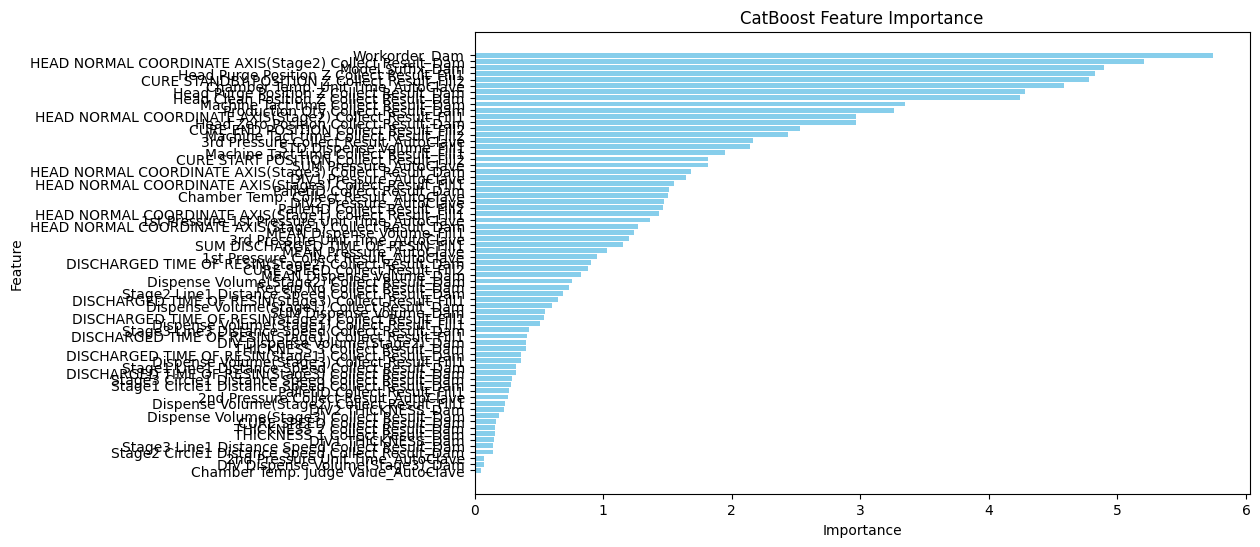

In [86]:
# Feature Importance 계산
import matplotlib.pyplot as plt
feature_importances = model.get_feature_importance()

# Feature Importance를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': train_x.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Feature Importance 출력
print(feature_importance_df)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 표시되도록 축 반전
plt.show()

In [88]:
feature_importance_df[:]

,Feature,Importance
1,Workorder_Dam,5.740362
18,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Re...,5.209428
16,Model.Suffix_Dam,4.895962
52,Head Purge Position Z Collect Result_Fill1,4.821969
34,CURE STANDBY POSITION Z Collect Result_Fill2,4.780323
...,...,...
55,Stage3 Line1 Distance Speed Collect Result_Dam,0.147109
44,Stage2 Circle1 Distance Speed Collect Result_Dam,0.141253
66,2nd Pressure Unit Time_AutoClave,0.076896
21,DIV Dispense Volume(Stage3)_Dam,0.072299


In [44]:
#re변경 케이스에 따라!!
feature_importance_df[-3:]['Feature'].unique() #확인

re=feature_importance_df[:-3]['Feature'].tolist()
train_x=train_x[re]
val_x=val_x[re]

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [51]:
#test_x=test_df.drop(columns=['Set ID','target'])

sub=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lg aimers 5기/submission.csv')


In [53]:
test_df['target']=model.predict(test_x)
sub['target'].replace({0:'Normal',1:'AbNormal'},inplace=True)

sub['target'].value_counts()


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="AJX75334501": Cannot convert 'b'AJX75334501'' to float

In [ ]:
# 제출 파일 저장
sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
